In [1]:
import pandas as pd
import numpy as np
import os, glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from datetime import datetime, timedelta
sns.set(style="whitegrid", font_scale=1)

In [2]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week #ofyear
    
    X = df[['dayofweek','quarter', 'month', 'weekofyear']]
    
   # X = df[['hour','dayofweek','quarter','month','year',
   #        'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

# Load data

## The cleaned data

In [295]:
## Hourly Energy Demand
# fileName_to_load = "data/energy.pkl"
# with open(fileName_to_load, 'rb') as fp:
#     data = pickle.load(fp)

# data.keys()

In [6]:
## Data with NaN
#energy_data = data['with_na']

## Data after imputing NaN
#df = data['fill_na']

In [294]:
#display(energy_data.head(5).T)
#display(df.head(5).T)

## Feature engineered data

In [3]:
## Feature engineered data
df = pd.read_csv('data/energy_feat.csv')

# convert the column (it's a string) to datetime type
df['time'] = pd.to_datetime(df['time'],
                          errors='coerce',
                          infer_datetime_format=True, utc=True
                          ).dt.tz_convert(None) + timedelta(hours=1)
# create datetime index passing the datetime series
df.set_index('time', inplace=True)

df.dtypes

generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
forecast solar day ahead                       float64
forecast wind onshore day ahead                float64
total load forecast                            float64
total load actual                              float64
price day 

In [4]:
df.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq=None)

# Modeling Part 1 (by hour)

## Stationarize the data

In [30]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    '''
    Null Hypothesis: The series has a unit root (non-stationary).
    Alternate Hypothesis: The series has no unit root (stationarity or trend-stationarity).
    '''
    print("Results of Dickey-Fuller Test: (Null - has unit root)")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    '''
    Null Hypothesis: The process is trend "stationary".
    Alternate Hypothesis: The series has a unit root (series is not stationary).
    
    Code adopt from
    https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
    '''
    print ('Results of KPSS Test: (Null - stationary)')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    

### Tests of stationary: Augmented Dickey–Fuller, KPSS 

In [431]:
temp = df['total load actual'].resample('1d').mean() #.iloc[:24*10]
temp1 = (temp - temp.rolling(7).mean()).dropna()
temp_diff24 = temp1.diff(7).dropna().copy()
temp_diff = temp1.diff().dropna().copy()

adf_test(temp)

Results of Dickey-Fuller Test:
Test Statistic                -6.476790e+00
p-value                        1.325038e-08
#Lags Used                     2.100000e+01
Number of Observations Used    1.439000e+03
Critical Value (1%)           -3.434902e+00
Critical Value (5%)           -2.863551e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


(1461,)

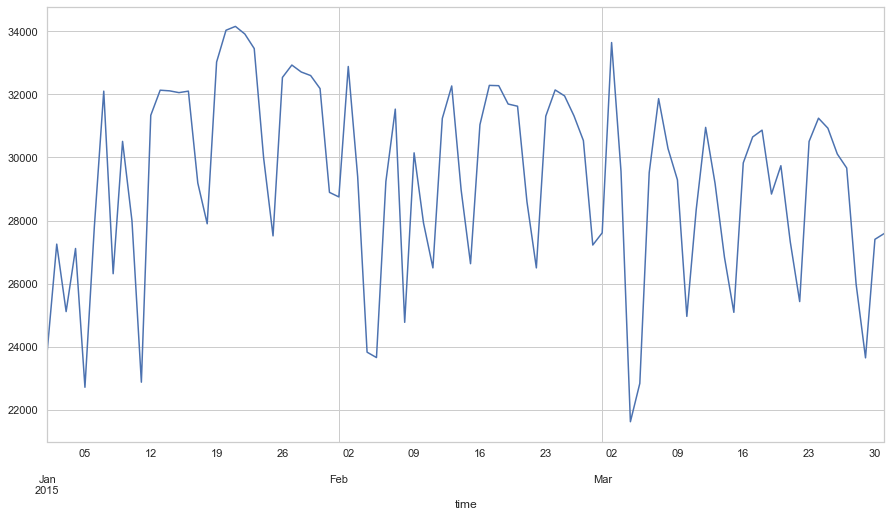

In [432]:
temp[:90].plot(figsize=(15,8))
temp.shape

In [433]:
kpss_test(temp1)

Results of KPSS Test:
Test Statistic             0.156202
p-value                    0.100000
Lags Used                160.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


### Examine the `acf`, `pacf` plot

In [155]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

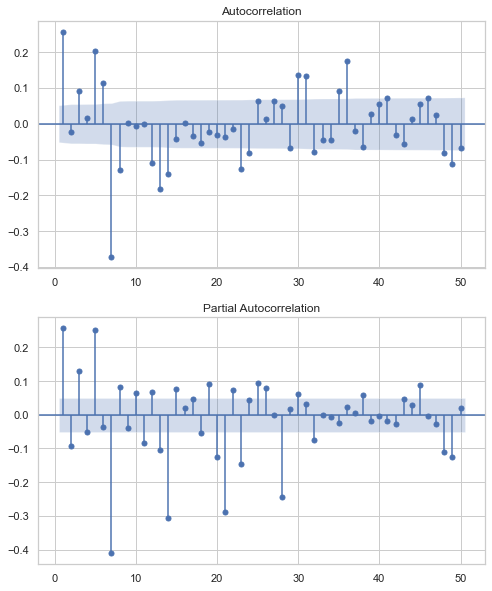

In [160]:
# Find seasonal (P, D, Q, S)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = temp1.diff(7).dropna() #df['total load actual']
plot_acf(input_data, lags=50, zero=False, ax=ax1)
plot_pacf(input_data, lags=50, zero=False, ax=ax2)
plt.show()


# Seasonal period S = 24 (hrs)

NameError: name 'plot_acf' is not defined

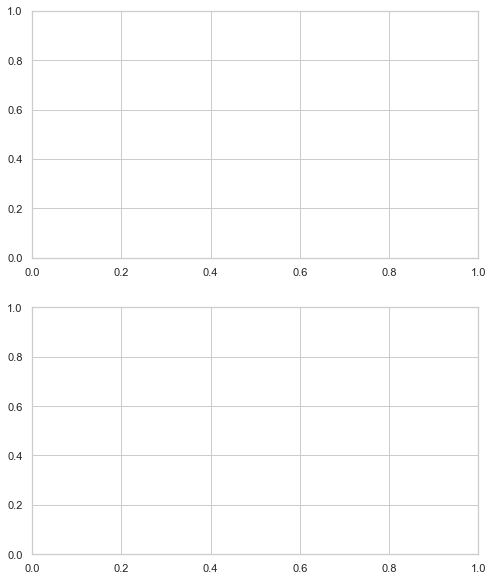

In [154]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = temp.diff(7).dropna()
#df['total load actual'].diff(24).dropna()#resample("1w").agg([np.mean])
plot_acf(input_data, lags=20, zero=False, ax=ax1)
plot_pacf(input_data, lags=20, zero=False, ax=ax2)
plt.show()

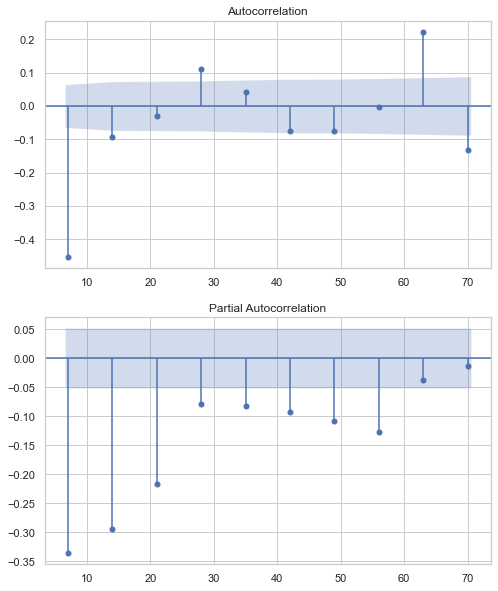

In [441]:
input_data = temp1.diff(7).diff().dropna()
#df['total load actual'].diff(24).dropna()
# input_data.plot()
# plt.show()

lags = np.arange(7, 77, 7)#np.arange(24, 288, 24)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.show()

## SARIMAX (by hour)

### Testing SARIMAX model

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm

In [ ]:
# ### Define Parameter Ranges to Test ###

# # Note: higher numbers will result in code taking much longer to run
# # Here we have it set to test p,d,q each = 0, 1 & 2

# # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
# p = d = q = range(0, 3)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the 's' position as we have monthly data
# # You'll want to change this according to your time series' frequency
# pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

# ### Run Grid Search ###

# # Note: this code will take a while to run

# # Define function
# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M', exog=None):
#     '''
#     Input: 
#         ts : your time series data
#         pdq : ARIMA combinations from above
#         pdqs : seasonal ARIMA combinations from above
#         maxiter : number of iterations, increase if your model isn't converging
#         frequency : default='M' for month. Change to suit your time series frequency
#             e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
#     Return:
#         Prints out top 5 parameter combinations
#         Returns dataframe of parameter combinations ranked by BIC
#     '''

#     # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
#                                                 order=comb,
#                                                 exog=exog,
#                                                 seasonal_order=combs,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False,
#                                                 freq=freq)

#                 output = mod.fit(maxiter=maxiter) 
#                 ans.append([comb, combs, output.bic])
#                 print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
#             except:
#                 continue
            
#     # Find the parameters with minimal BIC value

#     # Convert into dataframe
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

#     # Sort and return top 5 combinations
#     ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
#     return ans_df


In [ ]:
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
# sarimax_gridsearch(ts, pdq, pdqs, freq='M')

In [144]:
df_train = df.loc['2017-10':'2017-12',:]

df_test = df.loc['2018':].copy()

In [155]:

temp_full = df_train[['total load actual']]
exogs = df_train[['trend']]
temp = temp_full.copy()#.iloc[:-48].copy()


,trend
time,
2017-10-01 00:00:00+02:00,-2.427431
2017-10-01 01:00:00+02:00,-2.427431
2017-10-01 02:00:00+02:00,-2.427431
2017-10-01 03:00:00+02:00,-2.427431
2017-10-01 04:00:00+02:00,-2.427431
...,...
2017-12-31 19:00:00+01:00,-1.465384
2017-12-31 20:00:00+01:00,-1.465384
2017-12-31 21:00:00+01:00,-1.465384


time
2017-12-31 23:00:00+01:00    23680.0
Name: total load actual, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                    total load actual   No. Observations:                 2209
Model:             SARIMAX(0, 1, 2)x(4, 0, [1], 24)   Log Likelihood              -17430.427
Date:                              Mon, 26 Jul 2021   AIC                          34878.854
Time:                                      12:35:05   BIC                          34930.152
Sample:                                           0   HQIC                         34897.595
                                             - 2209                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend        -32.4731     24.082     -1.348      0.178     -79.673      14.726
ma.L1          0.53

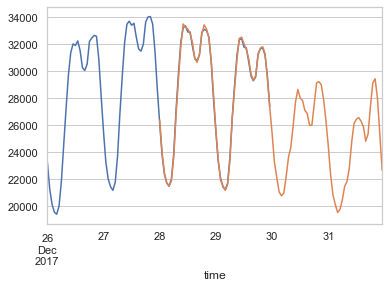

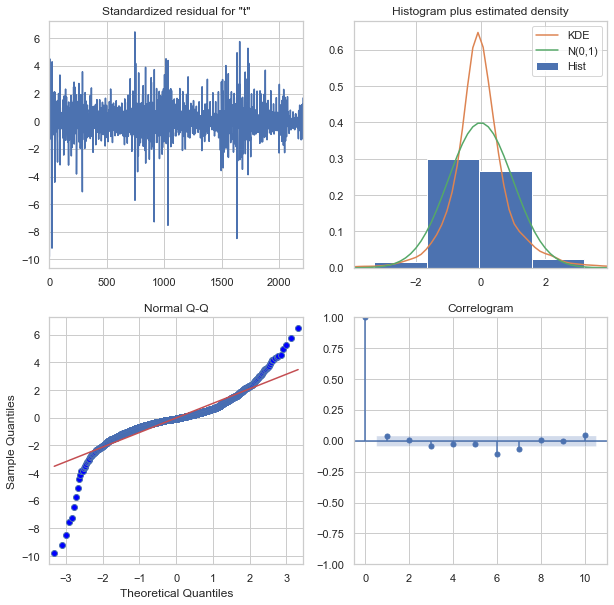

In [132]:

print(temp[-1:])

model = SARIMAX(temp, order=(0,1,2), seasonal_order=(4,0,1,24), exog=exogs, freq='H')
results = model.fit()

## 
print(results.summary())

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
#results.predict().plot(figsize=(10,5))
fig, ax = plt.subplots()
temp_full.iloc[-144:-48].plot(ax=ax)
results.predict().iloc[-96:].plot(ax=ax)
plt.show()

# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(10,10))
plt.show()


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


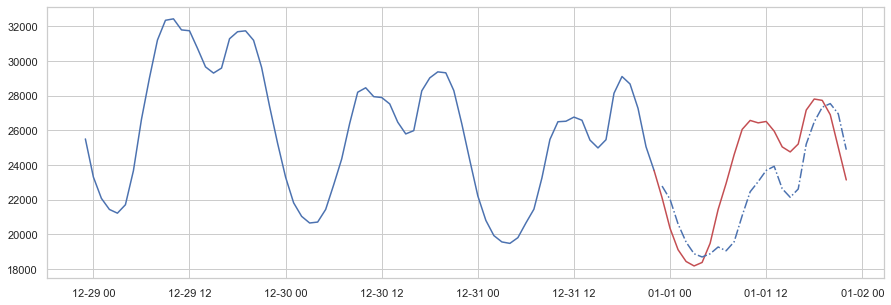

,Prediction
time,
2018-01-01 00:00:00+01:00,22105.570604
2018-01-01 01:00:00+01:00,20336.186731
2018-01-01 02:00:00+01:00,19103.921499
2018-01-01 03:00:00+01:00,18426.921328
2018-01-01 04:00:00+01:00,18169.607716
2018-01-01 05:00:00+01:00,18371.198564
2018-01-01 06:00:00+01:00,19474.072216
2018-01-01 07:00:00+01:00,21426.648164
2018-01-01 08:00:00+01:00,22935.928555


In [138]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
exog_test = df_test['trend'].iloc[:24]

forecast_period = len(exog_test)

forecast = results.forecast(forecast_period, exog=exog_test)

# date_range = pd.date_range(temp.index[-1], periods = forecast_period, 
#               freq='H').strftime("%Y-%m-%d-%H-%M-%S").tolist()

date_range = exog_test.index

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['time'])
future_months

# Let's now convert the 'Month' column to a datetime object with to_datetime 
# future_months['time'] = pd.to_datetime(future_months['time'])
future_months['Prediction'] = forecast.values
future_months.set_index('time', inplace = True)


# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,5))
plt.plot(temp_full.iloc[-72:])
#plt.plot(df_test['total load actual'].loc[future_months.index],'-.')
plt.plot(temp.iloc[-1:].append(future_months['Prediction']),'r-')
plt.plot(df_test['total load actual'].loc[future_months.index],'b-.')

plt.show()

future_months

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


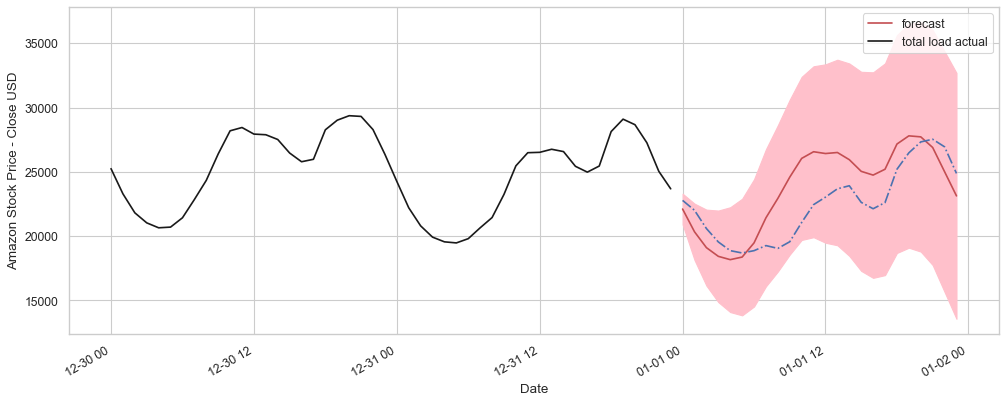

In [134]:
# Generate predictions
dynamic_forecast = results.get_forecast(steps=forecast_period, dynamic=True, exog=exog_test)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean.values

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower total load actual']
upper_limits = confidence_intervals.loc[:,'upper total load actual']

fig, ax=plt.subplots(1,1, figsize=(15,6), dpi=80)
# plot your mean forecast
plt.plot(date_range, mean_forecast, color='r', label='forecast')

# Shade the area between your confidence limits
plt.fill_between(exog_test.index, lower_limits, 
         upper_limits, color='pink')

df_train[-48:]['total load actual'].plot(style='k', ax=ax)
#temp_full[-72:].plot(style='k--',ax=ax)
plt.plot(df_test['total load actual'].loc[future_months.index],'-.')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()



### Auto arima (tried to find the best hyperparameters)

In [5]:
import pmdarima.arima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta



In [156]:
model1 = pm.auto_arima(temp,
                       exogenous=exogs,
                       seasonal=True,
                       m=24,
                       max_d=2,
                       max_P=2,
                       max_D=2,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=36151.722, Time=17.50 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=43269.088, Time=0.26 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=14.44 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=8.67 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=66475.477, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=36067.171, Time=10.60 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=36163.648, Time=2.49 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=35950.256, Time=69.47 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=36151.754, Time=62.82 sec
 ARIMA(1,0,2)(0,0,2)[24] intercept   : AIC=35414.431, Time=33.69 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=35565.955, Time=8.31 sec
 ARIMA(1,0,2)(1,0,2)[24] intercept   : AIC=35856.454, Time=41.95 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=35855.538, Time=11.96 sec
 ARIMA(0,0,2)(0,0,2)[24] intercept   : AIC=38431.831, Time=37.40 sec
 ARIMA(1

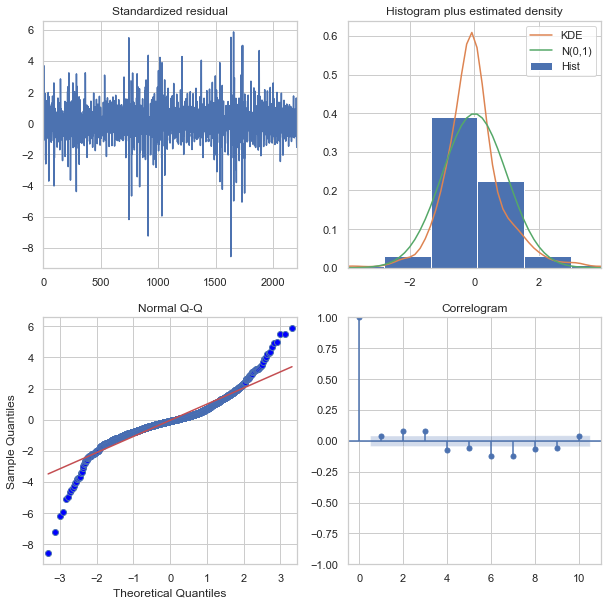

In [157]:
# Create the 4 diagostics plots
model1.plot_diagnostics(figsize=(10,10))
plt.show()

Forecasting the next 48 hours.

In [181]:

# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

exog_test = df_test[['trend']].iloc[:48]

date_range = exog_test.index

forecast_period = len(exog_test)

# date_range = pd.date_range(temp.index[-1], periods = forecast_period, 
#               freq='H').strftime("%Y-%m-%d-%H-%M-%S").tolist()
# date_range = pd.to_datetime(date_range)

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['time'])

# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['time'] = pd.to_datetime(future_months['time'])
future_months.set_index('time', inplace = True)


In [182]:
# Generate predictions
results = model1
dynamic_forecast, confidence_intervals = results.predict(
    n_periods=forecast_period, dynamic=True, return_conf_int=True, exogenous=exog_test)

# Extract prediction mean
mean_forecast = dynamic_forecast#.predicted_mean
future_months['Prediction'] = dynamic_forecast

# Get confidence intervals of predictions
# confidence_intervals = results.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals[:, 0]
upper_limits = confidence_intervals[:, 1]

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


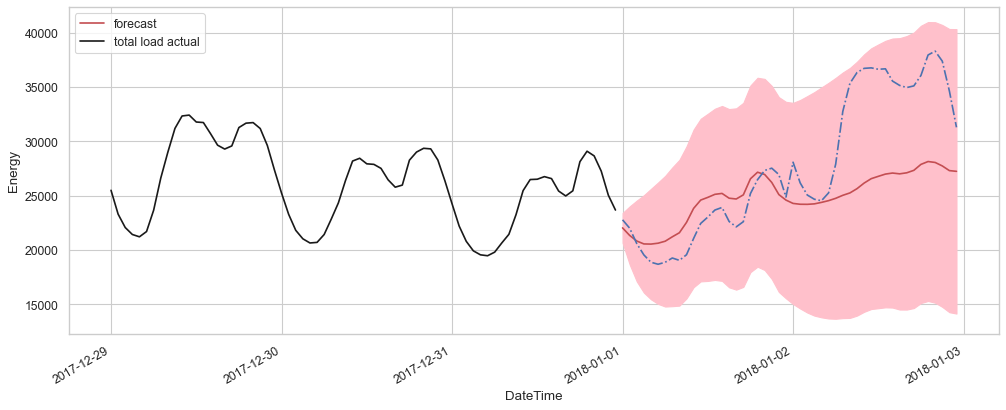

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=80)

# plot your mean forecast
ax.plot(date_range, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
ax.fill_between(date_range, lower_limits, upper_limits, color='pink')
temp_full.iloc[-72:].plot(style='k',ax=ax)
plt.plot(df_test['total load actual'].loc[future_months.index],'-.')

# set labels, legends and show plot
plt.xlabel('DateTime')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Save / Load trained auto ARIMA model

In [8]:
import joblib
# Set model name
filename = "enegy_model.pkl"

# Pickle it
#joblib.dump(model1, filename)

# Load trained model
# model_load = joblib.load(filename)

### Forecasting with pre-trained ARIMA model

In [6]:
def model_forecast(results, exog_test):
    '''
    results - the fitted model
    '''
    # Declare a variable called forecast_period with the amount of months to forecast, and
    # create a range of future dates that is the length of the periods you've chosen to forecast

    #exog_test = df_test[['trend']].iloc[:48]

    date_range = exog_test.index
    forecast_period = len(exog_test)

    # date_range = pd.date_range(temp.index[-1], periods = forecast_period,
    #               freq='H').strftime("%Y-%m-%d-%H-%M-%S").tolist()
    # date_range = pd.to_datetime(date_range)

    # Convert that range into a dataframe that includes your predictions
    future_pred = pd.DataFrame(date_range, columns=['time'])

    # Let's now convert the 'Month' column to a datetime object with to_datetime
    future_pred['time'] = pd.to_datetime(future_pred['time'])
    future_pred.set_index('time', inplace=True)

    # Generate predictions
    dynamic_forecast, confidence_intervals = results.predict(
        n_periods=forecast_period,
        dynamic=True,
        return_conf_int=True,
        exogenous=exog_test)

    # Extract prediction mean
    mean_forecast = dynamic_forecast  #.predicted_mean
    future_pred['Prediction'] = dynamic_forecast

    # Get confidence intervals of predictions
    # confidence_intervals = results.conf_int()

    # Select lower and upper confidence limits
    future_pred['lower_limits'] = confidence_intervals[:, 0]
    future_pred['upper_limits'] = confidence_intervals[:, 1]

    return future_pred

#### Two-day forecasting

In [7]:
# Load trained model
model_load = joblib.load(filename)

# Initialize train and test sets
df_train = df.loc['2017-10':'2017-12',:]
df_test = df.loc['2018':].copy()

NameError: name 'joblib' is not defined

In [304]:
# Two-day forecasting
exogs_1day = df_test[['trend']].iloc[:48]
future_pred = model_forecast(model_load, exogs_1day)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


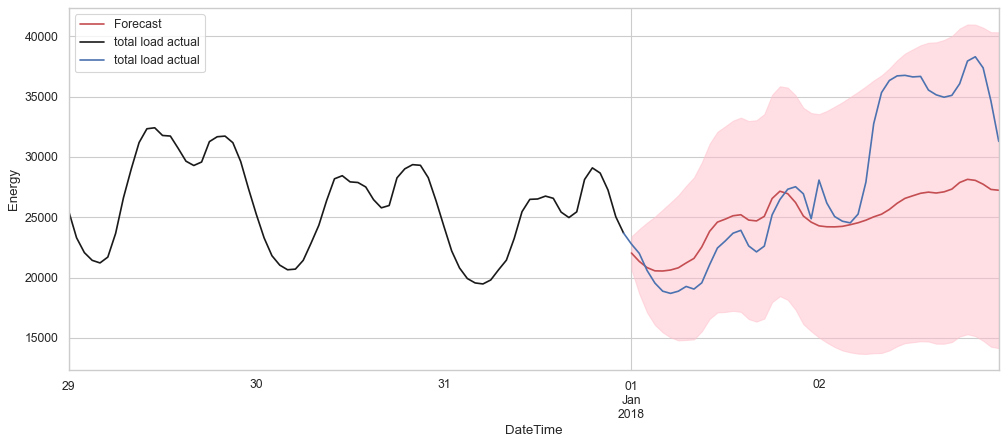

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=80)
# plot your mean forecast
future_pred['Prediction'].plot(color='r', label='Forecast', ax=ax)

# shade the area between your confidence limits
ax.fill_between(future_pred.index,
                future_pred['lower_limits'],
                future_pred['upper_limits'],
                color='pink',
                alpha=0.5)

# df_test[['total load forecast']].loc[future_pred.index].plot(style='k-.', ax=ax)
# df_train[['total load forecast']].iloc[-72:].plot(style='k-.', ax=ax)
df_train[['total load actual']].iloc[-72:].plot(style='k', ax=ax)
(df_train[['total load actual']].iloc[-1:].append(df_test[['total load actual'
                                     ]].loc[future_pred.index])).plot(ax=ax)

# set labels, legends and show plot
plt.xlabel('DateTime')
plt.ylabel('Energy')
plt.legend()

plt.show()

#### Forecasting with pre-trained ARIMA model (multiple days)

In [11]:
# Load trained model
model_load = joblib.load(filename)

# Initialize train and test sets
df_train = df.loc['2017-10':'2017-12',:].copy()
df_test = df.loc['2018':].copy()

In [12]:
future_preds = pd.DataFrame(columns=['time','Prediction', 'lower_limits', 'upper_limits'])
future_preds.set_index('time', inplace=True)

for i in range(25):
    # Forecasting day-by-day
    exogs_1day = df_test[['trend']].iloc[:24]
    future_1day = model_forecast(model_load, exogs_1day)
    future_preds = future_preds.append(future_1day)

    new_1day = df_test[['total load actual']].iloc[:24]#.copy()
    
    # update the model with extra one-day (24 hrs) actual observation
    model_load.update(new_1day, exogenous = exogs_1day) 

    df_train = df_train.append(df_test.iloc[:24])
    df_test = df_test.iloc[24:]

future_preds

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Prediction,lower_limits,upper_limits
time,,,
2018-01-01 00:00:00+01:00,22035.674110,20665.217721,23406.130500
2018-01-01 01:00:00+01:00,21341.266266,18667.779350,24014.753183
2018-01-01 02:00:00+01:00,20827.648037,17103.196630,24552.099445
2018-01-01 03:00:00+01:00,20558.145280,16074.327545,25041.963015
2018-01-01 04:00:00+01:00,20544.710086,15457.213218,25632.206954
...,...,...,...
2018-01-25 19:00:00+01:00,31399.606289,23064.480212,39734.732365
2018-01-25 20:00:00+01:00,31631.650367,23215.429953,40047.870780
2018-01-25 21:00:00+01:00,31256.722789,22766.918407,39746.527172


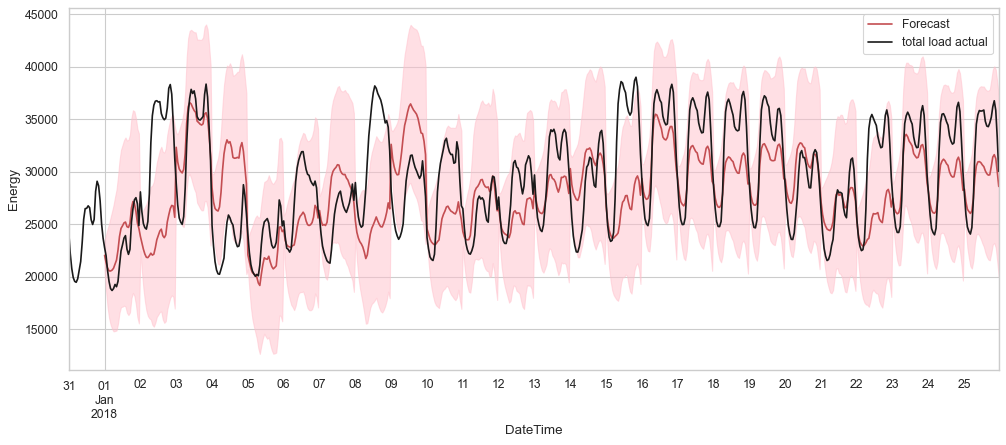

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=80)

# plot your mean forecast
future_preds['Prediction'].plot(color='r', label='Forecast', ax=ax)

# shade the area between your confidence limits
ax.fill_between(future_preds.index,
                future_preds['lower_limits'],
                future_preds['upper_limits'],
                color='pink',
                alpha=0.5)

# df_train[['total load forecast']].iloc[-120:].plot(style='k-.', ax=ax)
df_train[['total load actual']].iloc[-26*24:].plot(style='k', ax=ax)
# (df_train[['total load actual']].iloc[-1:].append(df_test[['total load actual'
#                                      ]].loc[future_pred.index])).plot(ax=ax)


#df_train[['trend']].iloc[-26*24:].plot(style='k', ax=ax)

# set labels, legends and show plot
plt.xlabel('DateTime')
plt.ylabel('Energy')
plt.legend()

plt.show()

## Prophet (by hour)

In [17]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from datetime import datetime

In [4]:
#datetime.strptime('2018-01-01', '%y-%m-%d')
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,price actual,total generation,temp,pressure,humidity,dayofweek,quarter,month,weekofyear,trend
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,65.41,28251.0,270.475000,1035.0,77.0,3,1,1,1,-2.031645
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,64.92,27818.0,269.763500,1035.0,97.0,3,1,1,1,-2.031645
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,64.48,26796.0,269.686000,1036.0,78.0,3,1,1,1,-2.031645
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,59.32,25223.0,269.203344,1035.0,97.0,3,1,1,1,-2.031645
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,56.04,24620.0,269.485500,1035.0,97.0,3,1,1,1,-2.031645


In [34]:
df_temp = df.reset_index().rename(columns={
    'time': 'ds',
    'trend': 'AvgTrend',
    'total generation': 'y'
}).set_index('ds')

forecast_start = '2018-01-02'
forecast_end = pd.to_datetime(forecast_start) + timedelta(days=14) - timedelta(hours=1)

train_start = pd.to_datetime(forecast_start) - timedelta(days=360)
train_end = pd.to_datetime(forecast_start) - timedelta(hours=1)

feat_col_sel = [
    'ds', 'temp', 'pressure', 'humidity', 'dayofweek', 'month', 'quarter', 'weekofyear', 'AvgTrend', 'y'
]
dfPh_train = df_temp.loc[train_start:train_end].reset_index()[feat_col_sel]
dfPh_test = df_temp.loc[forecast_start:forecast_end].reset_index()[feat_col_sel]

dfPh_test

,ds,temp,pressure,humidity,dayofweek,month,quarter,weekofyear,AvgTrend,y
0,2018-01-02 00:00:00,283.49,1027.0,71.0,1,1,1,1,-0.664355,25395.0
1,2018-01-02 01:00:00,283.16,1028.0,71.0,1,1,1,1,-0.664355,24465.0
2,2018-01-02 02:00:00,282.49,1027.0,66.0,1,1,1,1,-0.664355,23484.0
3,2018-01-02 03:00:00,284.15,1027.0,76.0,1,1,1,1,-0.664355,23016.0
4,2018-01-02 04:00:00,282.32,1027.0,81.5,1,1,1,1,-0.664355,23188.0
...,...,...,...,...,...,...,...,...,...,...
331,2018-01-15 19:00:00,281.27,1024.0,65.0,0,1,1,3,1.374594,36853.0
332,2018-01-15 20:00:00,281.65,1025.0,75.0,0,1,1,3,1.374594,36827.0
333,2018-01-15 21:00:00,281.67,1025.0,70.0,0,1,1,3,1.374594,36261.0
334,2018-01-15 22:00:00,281.27,1025.0,75.0,0,1,1,3,1.374594,33774.0


In [43]:
model = Prophet(seasonality_mode='additive',#'multiplicative',
                daily_seasonality=True,
                weekly_seasonality=True,
                changepoint_prior_scale=0.2,
                seasonality_prior_scale=1.5)
# model.add_regressor('quarter')
# model.add_regressor('dayofweek')
# model.add_regressor('month')
model.add_regressor('AvgTrend')
# model.add_regressor('dayofweek')
# model.add_regressor('weekofyear')
model.fit(dfPh_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [23]:
# # Python
# import itertools
# # import numpy as np
# # import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.2, 0.3, 0.4],#[0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [1.2, 1.4, 1.5], #[0.01, 0.1, 1.0, 10.0],
#     'daily_seasonality': [True]
# }

# cutoffs = pd.to_datetime(['2017-01-01', '2017-02-15', '2017-04-01', '2017-05-15', '2017-06-01'])

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     model = Prophet(**params)
#     model.fit(dfPh_train)  # Fit model with given params
#     df_cv = cross_validation(model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x11e21ed10>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1200fe890>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x12003bfd0>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x12008ad10>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x120466e10>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x11e23b650>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x120032e90>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x10815c410>
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1200320d0>
INFO:proph

    changepoint_prior_scale  seasonality_prior_scale  daily_seasonality  \
0                      0.05                      0.5               True   
1                      0.05                      1.0               True   
2                      0.05                      1.5               True   
3                      0.05                      2.0               True   
4                      0.10                      0.5               True   
5                      0.10                      1.0               True   
6                      0.10                      1.5               True   
7                      0.10                      2.0               True   
8                      0.20                      0.5               True   
9                      0.20                      1.0               True   
10                     0.20                      1.5               True   
11                     0.20                      2.0               True   

           rmse  
0   37

In [48]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.5, 'daily_seasonality': True}


In [53]:
# Format data for prophet model using ds and y


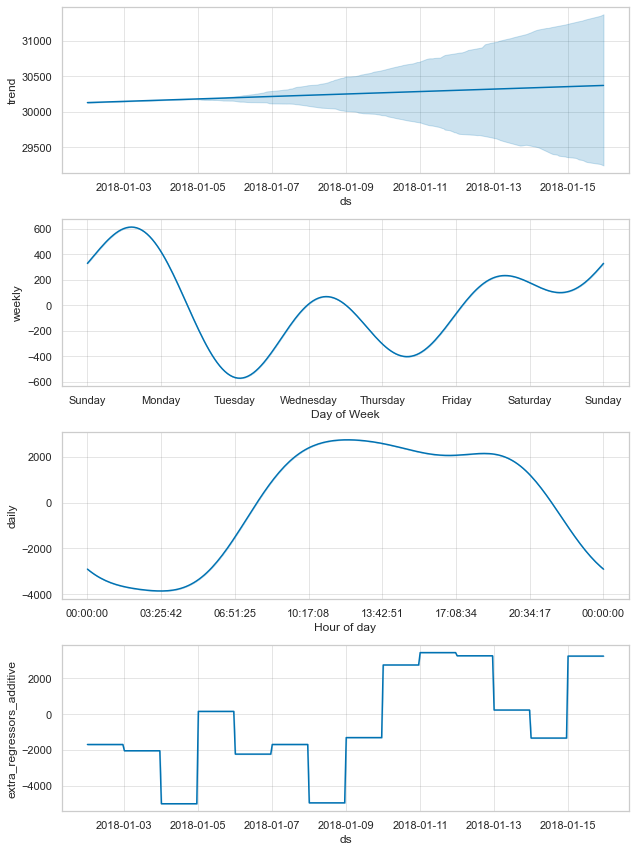

In [46]:
forcasts = model.predict(dfPh_test)
fig2 = model.plot_components(forcasts)


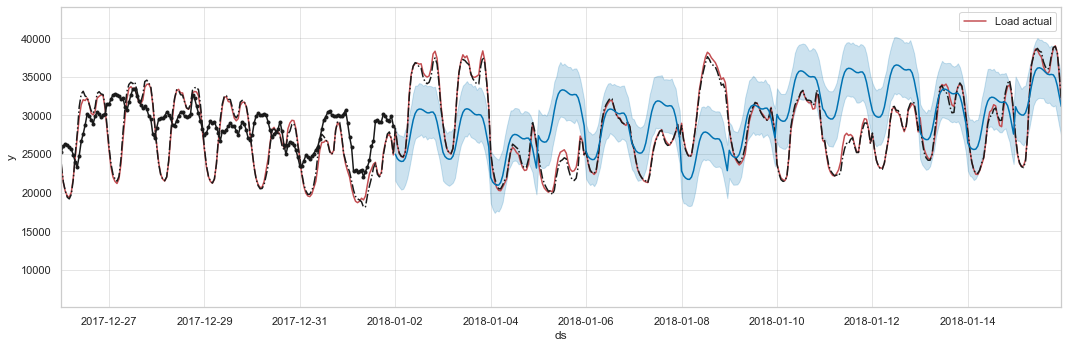

<Figure size 432x288 with 0 Axes>

In [64]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

t1 = pd.Timestamp(forecast_start)-timedelta(days=7)

ax.plot(df.loc[t1:forecast_end].index, df['total load actual'].loc[t1:forecast_end], color='r', label='Load actual')
ax.plot(df.loc[t1:forecast_end].index, df['total load forecast'].loc[t1:forecast_end], 'k-.')

line = model.plot(forcasts, ax=ax)

ax.set_xlim(t1,pd.Timestamp(forecast_end))
#ax.set_ylim(0, 60000)

line.set_label('Label via method')
ax.legend()
plt.plot(model.history['ds'].iloc[-240:].dt.to_pydatetime(), model.history['y'].iloc[-240:], 'k-')
plt.show()
plot = plt.suptitle('First Week of January Forecast vs Actuals')


In [65]:
#forcasts.yhat.plot()

In [65]:
help(model)

Help on Prophet in module prophet.forecaster object:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniformly

# Modeling Part 2 (by day)

* The hourly osillation is 

## Feature extract

We extract the daily min, max load from the original time series.

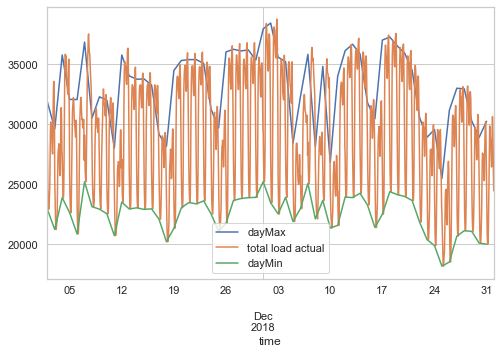

In [4]:
day_max = (df.resample('12h')[['total load actual']].max()).resample('1d').mean().rename(columns={'total load actual':'dayMax'})
#day_max.index = day_max.index+timedelta(hours=12)
day_min = df.resample('1d')[['total load actual']].min().rename(columns={'total load actual':'dayMin'})

fig, ax=plt.subplots(1,1,figsize=(8,5))
day_max.iloc[-60:].plot(ax=ax)
df[['total load actual']].iloc[-60*24:].plot(ax=ax)
day_min.iloc[-60:].plot(ax=ax)
plt.show()

In [5]:
day_min_max = day_min.join(day_max)
day_min_max.head()

,dayMin,dayMax
time,,
2015-01-01,19905.0,27478.0
2015-01-02,22066.0,31370.0
2015-01-03,21145.0,28416.5
2015-01-04,21929.0,30728.5
2015-01-05,19964.0,25336.5


In [6]:
#datetime.strptime('2018-01-01', '%y-%m-%d')

_ = create_features(day_min_max)
day_min_max.loc['2018-12-31','weekofyear'] = 53
#day_min_max.drop(columns='date',inplace=True)

day_min_max.head()


,dayMin,dayMax,date,dayofweek,quarter,month,weekofyear
time,,,,,,,
2015-01-01,19905.0,27478.0,2015-01-01,3,1,1,1
2015-01-02,22066.0,31370.0,2015-01-02,4,1,1,1
2015-01-03,21145.0,28416.5,2015-01-03,5,1,1,1
2015-01-04,21929.0,30728.5,2015-01-04,6,1,1,1
2015-01-05,19964.0,25336.5,2015-01-05,0,1,1,2


In [220]:

npl = day_min_max.copy()
smoothed_cases_max = []
smoothed_cases_min = []
for date in sorted(npl['date']):
    npl['gkv'] = np.exp(
        -(((npl['date'] - date).apply(lambda x: x.days)) ** 2) / (2 * (0.75 ** 2))
    )
    npl['gkv'] /= npl['gkv'].sum()
    smoothed_cases_max.append(round(npl['dayMax'] * npl['gkv']).sum())
    smoothed_cases_min.append(round(npl['dayMin'] * npl['gkv']).sum())

day_min_max['smoothed_dayMax'] = smoothed_cases_max
day_min_max['smoothed_dayMin'] = smoothed_cases_min

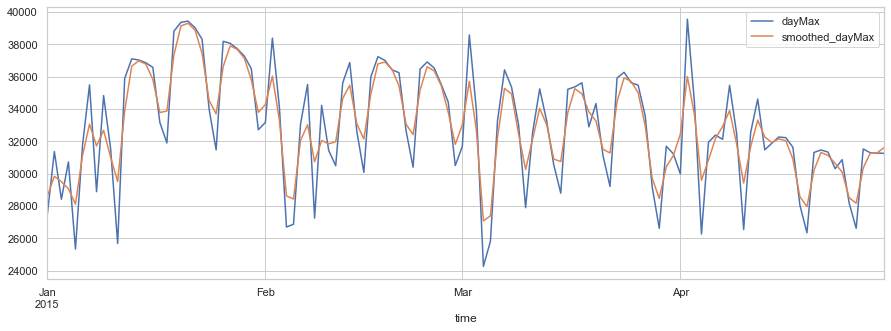

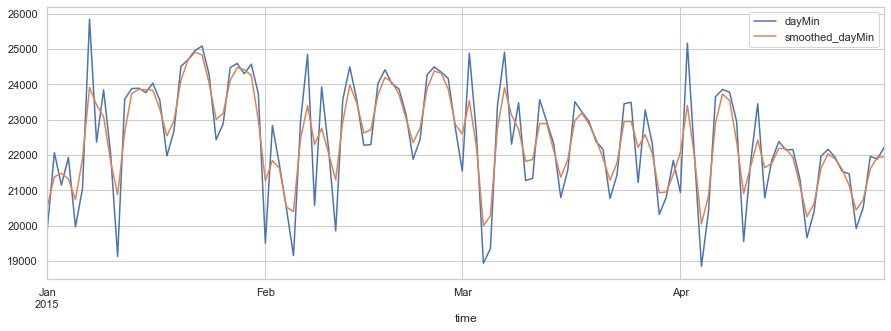

In [221]:
#day_min_max['smoothed_dayMax'] = smoothed_cases
day_min_max[['dayMax','smoothed_dayMax']].iloc[:120].plot(figsize=(15,5))
plt.show()

day_min_max[['dayMin','smoothed_dayMin']].iloc[:120].plot(figsize=(15,5))
plt.show()

## Stationarize the data (by day)

In [193]:
kpss_test(day_min_max['dayMin'])
print('\n')
adf_test(day_min_max['dayMin'])

Results of KPSS Test: (Null - stationary)
Test Statistic            0.735357
p-value                   0.010331
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Results of Dickey-Fuller Test: (Null - has unit root)
Test Statistic                -6.155954e+00
p-value                        7.368027e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.438000e+03
Critical Value (1%)           -3.434906e+00
Critical Value (5%)           -2.863552e+00
Critical Value (10%)          -2.567841e+00
dtype: float64


In [31]:
# temp1=day_min_max['dayMin'].dropna()
# kpss_test(day_min_max['dayMin'])
kpss_test(day_min_max['smoothed_dayMax'])
print('\n')
adf_test(day_min_max['smoothed_dayMax'])

Results of KPSS Test: (Null - stationary)
Test Statistic            0.328092
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Results of Dickey-Fuller Test: (Null - has unit root)
Test Statistic                -6.795948e+00
p-value                        2.300857e-09
#Lags Used                     2.300000e+01
Number of Observations Used    1.437000e+03
Critical Value (1%)           -3.434909e+00
Critical Value (5%)           -2.863553e+00
Critical Value (10%)          -2.567842e+00
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


## SARIMAX (by day)

In [222]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm

In [228]:
df_temp = day_min_max.reset_index().rename(columns={
    'time': 'ds',
    'smoothed_dayMin':'y' #'smoothed_dayMax': 'y' #'dayMax':'y'
}).set_index('ds')

forecast_start = '2018-01-01'
forecast_end = pd.to_datetime(forecast_start) + timedelta(days=14) - timedelta(hours=1)

train_start = pd.to_datetime(forecast_start) - timedelta(days=360)
train_end = pd.to_datetime(forecast_start) - timedelta(hours=1)

feat_col_sel = [
    'dayofweek', 'month', 'quarter', 'weekofyear', 'y', 'smoothed_dayMax'
]

df_train = df_temp.loc[:train_end][feat_col_sel]
df_test = df_temp.loc[forecast_start:forecast_end][feat_col_sel]


df_test.head()

,dayofweek,month,quarter,weekofyear,y,smoothed_dayMax
ds,,,,,,
2018-01-01,0,1,1,1,20266.0,28697.0
2018-01-02,1,1,1,1,23213.0,34649.0
2018-01-03,2,1,1,1,23677.0,35245.0
2018-01-04,3,1,1,1,21329.0,29670.0
2018-01-05,4,1,1,1,20680.0,27904.0


In [229]:
temp_full = df_train[['y']]
exogs = None #df_train[['trend']]
temp = temp_full.copy()#.iloc[:-48].copy()

                  y
ds                 
2017-12-31  19662.0


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1096
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 7)   Log Likelihood               -8505.038
Date:                           Mon, 02 Aug 2021   AIC                          17032.076
Time:                                   19:29:21   BIC                          17086.989
Sample:                               01-01-2015   HQIC                         17052.861
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4166      0.023     17.945      0.000       0.371       0.462
ar.L2         -0.6658      0.023    -28.687

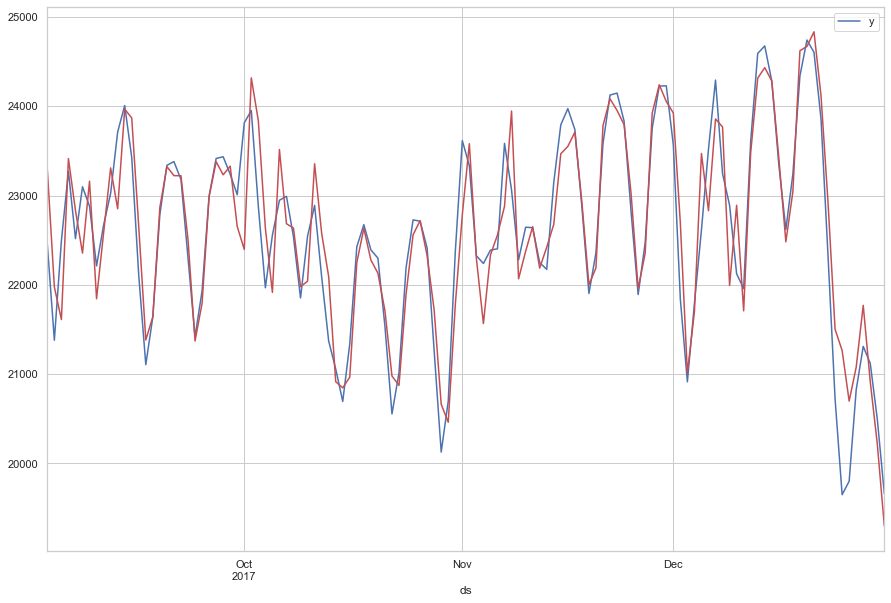

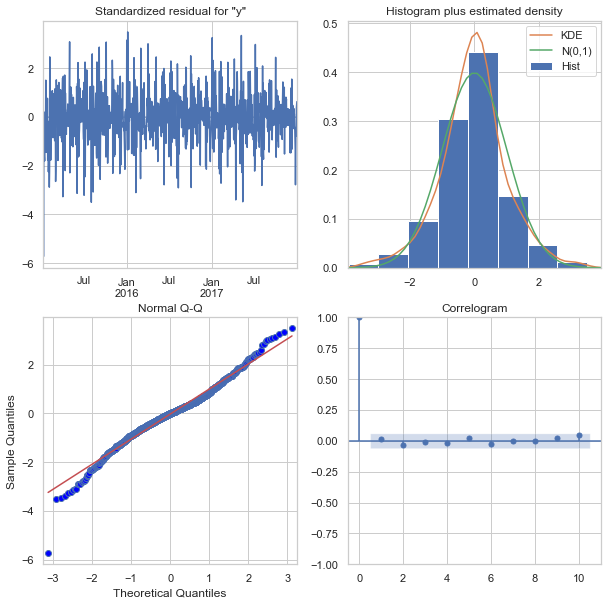

In [230]:

print(temp[-1:])

#  order=(4,1,0), seasonal_order=(3,1,1,7) for smoothed_dayMax
#  order=(5,1,0), seasonal_order=(5,1,0,7) for dayMax

# Remember to change frequency to match your time series data
model = SARIMAX(temp, order=(5,1,0), seasonal_order=(5,1,0,7), freq='D') #exog=exogs,
results = model.fit()

## 
print(results.summary())

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
#results.predict().plot(figsize=(10,5))
fig, ax = plt.subplots(figsize=(15,10))
temp_full.iloc[-120:].plot(ax=ax)

results.predict().iloc[-120:].plot(color='r',ax=ax)
#df_test['dayMax'].iloc[:120].plot(color='k',ax=ax)
#df_train['dayMax'].iloc[-120:].plot(color='k',ax=ax)
plt.show()

# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(10,10))
plt.show()



In [64]:
#temp.iloc[-1:].append(future_months[['y']])

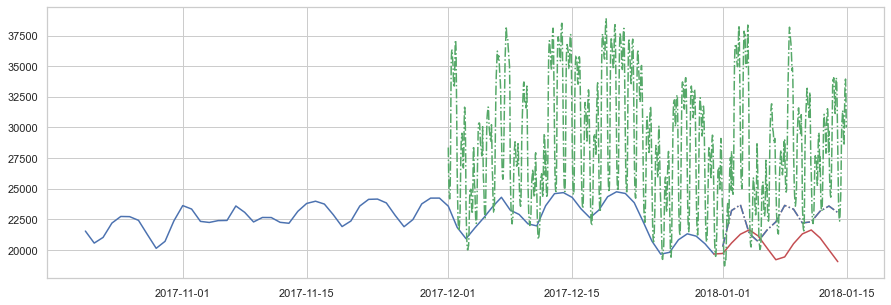

,y
ds,
2018-01-01,19704.710288
2018-01-02,20561.944748
2018-01-03,21277.819129
2018-01-04,21634.397726
2018-01-05,21138.509071
2018-01-06,20155.550043
2018-01-07,19196.509805
2018-01-08,19424.738275
2018-01-09,20502.806982


In [231]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
exog_test = None #df_test['trend'].iloc[:24]

forecast_period = len(df_test)

forecast = results.forecast(forecast_period)#, exog=exog_test)

# date_range = pd.date_range(temp.index[-1], periods = forecast_period, 
#               freq='H').strftime("%Y-%m-%d-%H-%M-%S").tolist()

date_range = df_test.index

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['ds'])

# Let's now convert the 'Month' column to a datetime object with to_datetime 
# future_months['time'] = pd.to_datetime(future_months['time'])
future_months['y'] = forecast.values
future_months.set_index('ds', inplace = True)


# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,5))
plt.plot(temp_full.iloc[-72:])
plt.plot(df_test['y'].loc[future_months.index],'-.')
plt.plot(temp.iloc[-1:].append(future_months[['y']]),'r-')
plt.plot(df_test['y'].loc[future_months.index],'b-.')
plt.plot(df['total load actual'].loc['2017-12-1':forecast_end],'g-.')

plt.show()

future_months

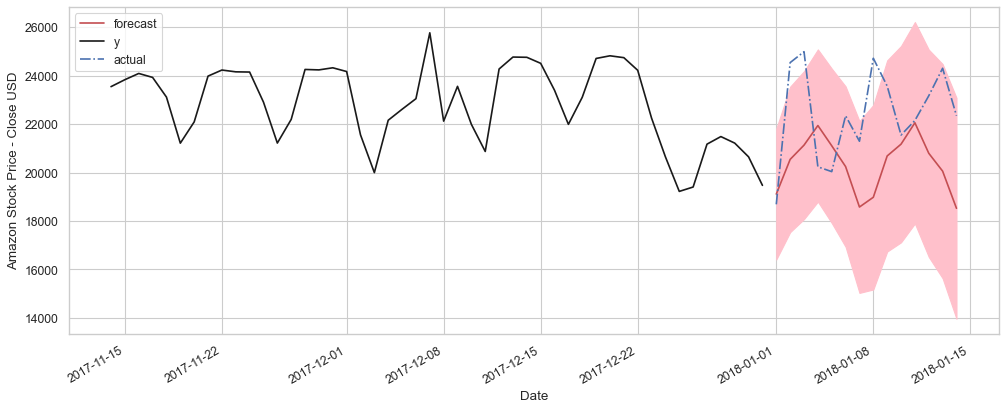

In [227]:
# Generate predictions
dynamic_forecast = results.get_forecast(steps=forecast_period, dynamic=True, exog=exog_test)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean.values

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower y']
upper_limits = confidence_intervals.loc[:,'upper y']

fig, ax = plt.subplots(1,1, figsize=(15,6), dpi=80)
# plot your mean forecast
plt.plot(date_range, mean_forecast, color='r', label='forecast')

# Shade the area between your confidence limits
plt.fill_between(df_test.index, lower_limits, 
         upper_limits, color='pink')

df_train[-48:]['y'].plot(style='k', ax=ax)
#temp_full[-72:].plot(style='k--',ax=ax)
plt.plot(df_test['y'].loc[future_months.index],'-.', label='actual')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()



In [232]:
import joblib
# Set model name
filename = "enegy_smoothed_dayMin.pkl" #"enegy_smoothed_dayMax.pkl"

# Pickle it
#joblib.dump(results, filename)

['enegy_smoothed_dayMin.pkl']

###  Forecasting each day (updating the pre-trained model with daily observation)

In [233]:
#SARIMAX.update(params,
def model_forecast(results, df_test):
    '''
    results - the fitted model
    '''
    # Declare a variable called forecast_period with the amount of months to forecast, and
    # create a range of future dates that is the length of the periods you've chosen to forecast

    date_range = df_test.index
    forecast_period = len(df_test)

    # Convert that range into a dataframe that includes your predictions
    future_pred = pd.DataFrame(date_range, columns=['ds'])

    # Let's now convert the 'Month' column to a datetime object with to_datetime
    future_pred['ds'] = pd.to_datetime(future_pred['ds'])
    future_pred.set_index('ds', inplace=True)

    # Generate predictions
    dynamic_forecast = results.get_forecast(
        steps=forecast_period, dynamic=True)
     #, exog=exog_test)
    #results.forecast(, dynamic=True)

    # Extract prediction mean
    mean_forecast = dynamic_forecast.predicted_mean.values
    future_pred['Prediction'] = mean_forecast

    # Get confidence intervals of predictions
    confidence_intervals = dynamic_forecast.conf_int()

    # Select lower and upper confidence limits
    future_pred['lower_limits'] = confidence_intervals.iloc[:, 0]
    future_pred['upper_limits'] = confidence_intervals.iloc[:, 1]

    #print(future_pred)
    return future_pred

In [234]:
future_preds = pd.DataFrame(columns=['ds','Prediction', 'lower_limits', 'upper_limits'])
future_preds.set_index('ds', inplace=True)
model_forecast(results, df_test.iloc[:1])

,Prediction,lower_limits,upper_limits
ds,,,
2018-01-01,19704.710288,18569.020414,20840.400163


In [253]:
# Initialize train and test sets
df_temp = day_min_max.reset_index().rename(columns={
    'time': 'ds',
    'smoothed_dayMax':'y' #'smoothed_dayMax': 'y'# 'dayMax':'y'# 'smoothed_dayMax': 'y'
}).set_index('ds')

forecast_start = '2018-01-01'
#forecast_end = pd.to_datetime(forecast_start) + timedelta(days=120) - timedelta(hours=1)

#train_start = pd.to_datetime(forecast_start) - timedelta(days=360)
train_end = pd.to_datetime(forecast_start) - timedelta(hours=1)

# select relavant features
feat_col_sel = [
    'dayofweek', 'month', 'quarter', 'weekofyear', 'y', 'dayMin', 'dayMax', #'smoothed_dayMax'#, 'dayMax'
]

df_train = df_temp.loc[:train_end][feat_col_sel]
df_test = df_temp.loc[forecast_start:][feat_col_sel]

display(df_test.head())
df_test.shape

,dayofweek,month,quarter,weekofyear,y,dayMin,dayMax
ds,,,,,,,
2018-01-01,0,1,1,1,28697.0,18688.0,25156.5
2018-01-02,1,1,1,1,34649.0,24537.0,37542.5
2018-01-03,2,1,1,1,35245.0,24987.0,38104.0
2018-01-04,3,1,1,1,29670.0,20235.0,27323.0
2018-01-05,4,1,1,1,27904.0,20037.0,26269.5


(365, 7)

In [254]:
# Load trained model
model_load = joblib.load("enegy_smoothed_dayMax.pkl")  #enegy_smoothed_dayMin
#model_load = results

# Initialize the prediction DataFrame
future_preds = pd.DataFrame(columns=['ds','Prediction', 'lower_limits', 'upper_limits'])
future_preds.set_index('ds', inplace=True)

for i in range(0,len(df_test)):
    # Forecasting day-by-day
    #exogs_1day = df_test[['trend']].iloc[:1]
    
    new_1day = df_test[['y']].iloc[:1].copy()
    
    future_1day = model_forecast(model_load, new_1day)
    future_preds = future_preds.append(future_1day)
    
    # update the model with extra one-day (24 hrs) actual observation
    model_load = model_load.extend(new_1day)#, exogenous = exogs_1day) 
    df_train = df_train.append(df_test.iloc[:1])
    df_test = df_test.iloc[1:]

future_preds = future_preds.join(df_train.loc[future_preds.index, ['y','dayMax']])

display(future_preds.shape)
future_preds.head()

(365, 5)

,Prediction,lower_limits,upper_limits,y,dayMax
ds,,,,,
2018-01-01,29011.769313,26657.684761,31365.853865,28697.0,25156.5
2018-01-02,30715.068556,28360.984004,33069.153108,34649.0,37542.5
2018-01-03,37054.529513,34700.444961,39408.614064,35245.0,38104.0
2018-01-04,32114.398089,29760.313537,34468.482641,29670.0,27323.0
2018-01-05,27493.724055,25139.639504,29847.808607,27904.0,26269.5


In [265]:
#future_preds_min=future_preds.copy()

df_train

,dayofweek,month,quarter,weekofyear,y,dayMin,dayMax
ds,,,,,,,
2015-01-01,3,1,1,1,28609.0,19905.0,27478.0
2015-01-02,4,1,1,1,29839.0,22066.0,31370.0
2015-01-03,5,1,1,1,29509.0,21145.0,28416.5
2015-01-04,6,1,1,1,29069.0,21929.0,30728.5
2015-01-05,0,1,1,2,28120.0,19964.0,25336.5
...,...,...,...,...,...,...,...
2018-12-27,3,12,4,52,32443.0,20676.0,33015.5
2018-12-28,4,12,4,52,32300.0,21132.0,32964.0
2018-12-29,5,12,4,52,30616.0,21084.0,30288.0


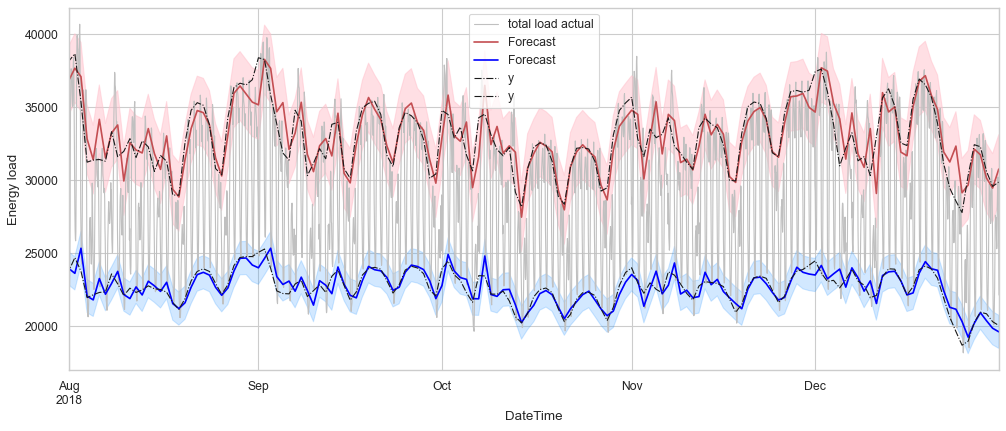

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=80)

# plot your mean forecast
df[['total load actual']].loc[future_preds.index[0]:].plot(style='-',color='silver',linewidth=1, ax=ax)
future_preds['Prediction'].plot(color='r', label='Forecast', ax=ax)
future_preds_min['Prediction'].plot(color='blue', label='Forecast', ax=ax)

# shade the area between your confidence limits
ax.fill_between(future_preds.index,
                future_preds['lower_limits'],
                future_preds['upper_limits'],
                color='pink',
                alpha=0.5)

ax.fill_between(future_preds_min.index,
                future_preds_min['lower_limits'],
                future_preds_min['upper_limits'],
                color='dodgerblue',
                alpha=0.2)

future_preds[['y']].loc[future_preds.index].plot(style='k-.',linewidth=1, ax=ax)
future_preds_min[['y']].loc[future_preds.index].plot(style='k-.',linewidth=1, ax=ax)
#df_train[['dayMax']].loc[future_preds.index].plot(style='k--', linewidth=0.8, ax=ax)
#df_train[['smoothed_dayMax']].loc[future_preds.index].plot(style='k--', linewidth=0.8, ax=ax)
# (df_train[['total load actual']].iloc[-1:].append(df_test[['total load actual'
#                                      ]].loc[future_pred.index])).plot(ax=ax)


#df_train[['trend']].iloc[-26*24:].plot(style='k', ax=ax)

# set labels, legends and show plot
plt.xlabel('DateTime')
plt.ylabel('Energy load')
plt.legend()

ax.set_xlim('2018-08-01',pd.Timestamp(future_preds.index[-1]))

plt.show()

### Residual Autocorrelation Plot

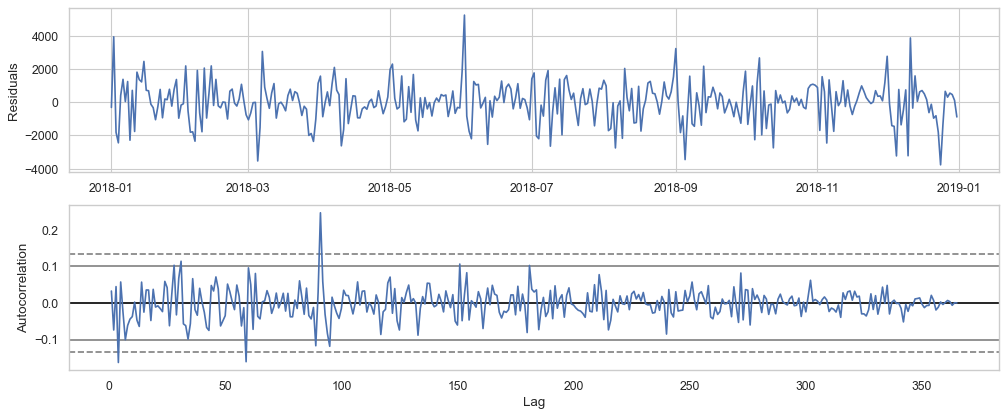

In [270]:
residuals = future_preds['y'] - future_preds['Prediction']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), dpi=80)
ax1.plot(residuals)
ax1.set_ylabel('Residuals')
#ax1.set_xlabel('Date')
#plt.show()

pd.plotting.autocorrelation_plot(residuals, ax=ax2)
plt.show()

In [ ]:
###

In [239]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [268]:
### R-square score (Coefficient of determination)
# y: the smoothed-dayMax
print('R-square:',r2_score(future_preds['y'], future_preds['Prediction']))
print('MAE:', mean_absolute_error(future_preds['y'], future_preds['Prediction']))
print('MSE:', mean_squared_error(future_preds['y'], future_preds['Prediction']))

R-square: 0.7506766100221196
MAE: 894.8270521405046
MSE: 1462354.9573100237


In [269]:
print('R-square:',r2_score(future_preds['dayMax'], future_preds['Prediction']))
print('MAE:',mean_absolute_error(future_preds['dayMax'], future_preds['Prediction']))#/np.std(future_preds['dayMax']))
print('MSE:',mean_squared_error(future_preds['dayMax'], future_preds['Prediction']))#/np.std(future_preds['dayMax']))

R-square: 0.5753512942952872
MAE: 1683.8529335259946
MSE: 4791828.311111981


In [271]:
# y: the smoothed-dayMin
print('R-square:',r2_score(future_preds_min['y'], future_preds_min['Prediction']))
print('MAE:', mean_absolute_error(future_preds_min['y'], future_preds_min['Prediction']))
print('MSE:', mean_squared_error(future_preds_min['y'], future_preds_min['Prediction']))

R-square: 0.7490707438688236
MAE: 435.13087100789363
MSE: 345819.233036331


In [273]:
print('R-square:',r2_score(future_preds_min['dayMin'], future_preds_min['Prediction']))
print('MAE:',mean_absolute_error(future_preds_min['dayMin'], future_preds_min['Prediction']))#/np.std(future_preds['dayMax']))
print('MSE:',mean_squared_error(future_preds_min['dayMin'], future_preds_min['Prediction']))#/np.std(future_preds['dayMax']))


R-square: 0.59751954174401
MAE: 722.727211817243
MSE: 980780.9744920658


## Prophet (by hour)

In [81]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from datetime import datetime

In [82]:
day_min_max.head()

,dayMin,dayMax,dayofweek,quarter,month,weekofyear
time,,,,,,
2015-01-01,19905.0,27478.0,3,1,1,1
2015-01-02,22066.0,31370.0,4,1,1,1
2015-01-03,21145.0,28416.5,5,1,1,1
2015-01-04,21929.0,30728.5,6,1,1,1
2015-01-05,19964.0,25336.5,0,1,1,2


In [83]:
df_temp = day_min_max.reset_index().rename(columns={
    'time': 'ds',
    'dayMax': 'y'
}).set_index('ds')

forecast_start = '2018-01-01'
forecast_end = pd.to_datetime(forecast_start) + timedelta(days=14) - timedelta(hours=1)

train_start = pd.to_datetime(forecast_start) - timedelta(days=360)
train_end = pd.to_datetime(forecast_start) - timedelta(hours=1)

feat_col_sel = [
    'ds', 'dayofweek', 'month', 'quarter', 'weekofyear', 'y'
]
dfPh_train = df_temp.loc[:train_end].reset_index()[feat_col_sel]
dfPh_test = df_temp.loc[forecast_start:forecast_end].reset_index()[feat_col_sel]

dfPh_test

,ds,dayofweek,month,quarter,weekofyear,y
0,2018-01-01,0,1,1,1,25156.5
1,2018-01-02,1,1,1,1,37542.5
2,2018-01-03,2,1,1,1,38104.0
3,2018-01-04,3,1,1,1,27323.0
4,2018-01-05,4,1,1,1,26269.5
5,2018-01-06,5,1,1,1,31736.5
6,2018-01-07,6,1,1,1,27839.0
7,2018-01-08,0,1,1,2,37292.5
8,2018-01-09,1,1,1,2,30859.0
9,2018-01-10,2,1,1,2,32688.0


In [84]:
del model
model = Prophet(seasonality_mode='multiplicative',#'multiplicative', 'additive'
                weekly_seasonality=True,
                yearly_seasonality=True,
                changepoint_prior_scale=0.2,
                seasonality_prior_scale=1.5)
# model.add_regressor('quarter')
# model.add_regressor('dayofweek')
# model.add_regressor('month')
# model.add_regressor('dayofweek')
# model.add_regressor('dayofweek')
# model.add_regressor('weekofyear')
model.fit(dfPh_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [201]:
# # Python
# import itertools
# # import numpy as np
# # import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.2, 0.3, 0.4],#[0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [1.2, 1.4, 1.5], #[0.01, 0.1, 1.0, 10.0],
#     'daily_seasonality': [True]
# }

# cutoffs = pd.to_datetime(['2017-01-01', '2017-02-15', '2017-04-01', '2017-05-15', '2017-06-01'])

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     model = Prophet(**params)
#     model.fit(dfPh_train)  # Fit model with given params
#     df_cv = cross_validation(model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [48]:
# Python
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.5, 'daily_seasonality': True}


In [53]:
# Format data for prophet model using ds and y


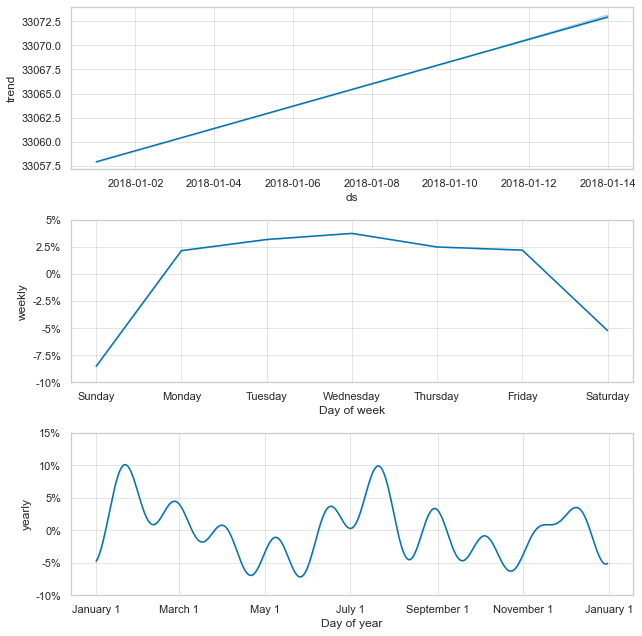

In [85]:
forcasts = model.predict(dfPh_test)
fig2 = model.plot_components(forcasts)


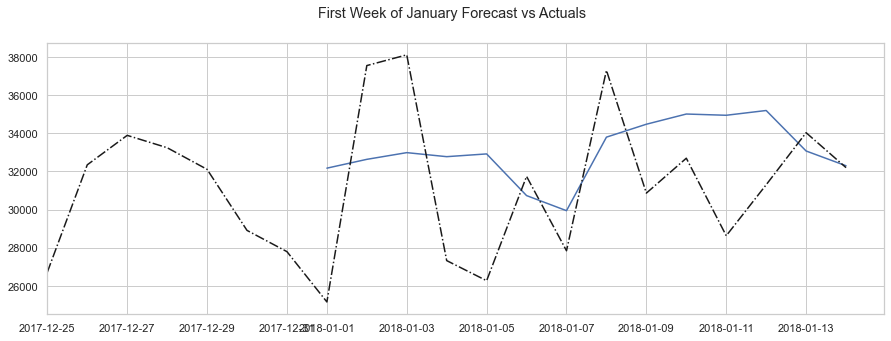

In [121]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

t1 = pd.Timestamp(forecast_start)-timedelta(days=7)
plt.plot(forcasts['ds'].values, forcasts['yhat'].values)
#model.plot(forcasts, ax=ax)
#ax.plot(df.loc[forecast_start:forecast_end].index, df['total load actual'].loc[t1:forecast_end], color='r', label='Load actual')
ax.plot(day_min_max.loc[t1:forecast_end].index, day_min_max['dayMax'].loc[t1:forecast_end], 'k-.')
ax.set_xlim(t1,pd.Timestamp(forecast_end))
#ax.set_ylim(0, 60000)

# line.set_label('Label via method')
# ax.legend()
#plt.plot(model.history['ds'].iloc[-240:].dt.to_pydatetime(), model.history['y'].iloc[-240:], 'k-')

plot = plt.suptitle('First Week of January Forecast vs Actuals')
plt.show()

In [ ]:
### Testing SARIMAX model